In [1]:
from pathlib import Path
import os
import warnings

from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import pandas as pd
import plotly.offline as pyo
import plotly.graph_objs as go
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import spacy

In [2]:
# Enable in-notebook visualizations
%matplotlib inline

In [3]:
nlp = spacy.load('es_md')

In [4]:
def iter_documents(directory, lang, other=None):
    """
    Parameters
    ----------
    directory: str   
    lang: spacy.lang
    other: dict, optional
    
    Yields
    ------
    list of str
        Itera sobre cada documento en directory, 
        devolviendo lista de palabras de cada uno a la vez, 
        filtrando según criterios en other.
    """
    cpath = Path(directory)
    for fpath in cpath.glob('*.txt'):
        with open(fpath, encoding='utf-8') as f:
            text = f.read()
        
        doc = lang(text)
        
        tokens = (tok for tok in doc if tok.is_alpha and not tok.is_stop)
        
        if other:
            if 'stopwords' in other:
                tokens = (tok for tok in tokens if tok.lower_ not in other['stopwords'])
            if 'postags' in other:
                tokens = (tok for tok in tokens if tok.pos_ in other['postags'])
            if 'entities' in other:
                tokens = (tok for tok in tokens if tok.ent_type_ not in other['entities'])
        
        wordlist = [tok.lower_ for tok in tokens]
        if other and 'stemmer' in other:
            wordlist = [other['stemmer'].stem(w) for w in wordlist]
            
        yield wordlist

In [5]:
class CorpusConsultivos:
    """
    Iterable: en cada iteración devuelve vectores bag-of-words, uno por documento.
    Procesa un documento a la vez usando generators. Nunca carga todo el corpus a RAM.
    """
    def __init__(self, directorio, lenguaje, otros=None):
        self.directorio = directorio
        self.lenguaje = lenguaje
        self.otros = otros
        
        self.diccionario = Dictionary(iter_documents(self.directorio, self.lenguaje, self.otros))
        # opcionalmente acá se podría reducir tamaño de diccionario usando
        # filter_tokens y compactify, o filter_extremes
        # corpus actual no da pa esto.
 
    def __iter__(self):
        """
        CorpusConsultivos es un streamed iterable.
        """
        for tokens in iter_documents(self.directorio, self.lenguaje, self.otros):
            yield self.diccionario.doc2bow(tokens)

In [6]:
def create_models(corpus, topics, params, directory, lang, other=None):
    """
    Crea modelos LDA para diferentes números de tópicos

    Parameters
    ----------
    corpus: CorpusConsultivos
    topics: iterable con el # de tópicos
    params: dict con parámetros requeridos en modelo
    directory: str   
    lang: spacy.lang
    other: dict, optional
    
    Returns
    -------
    dict of str
        Dict con resultados de modelos LDA
    """
    models = {}
    
    for i in topics:
        result = {}
        id2word = corpus.diccionario
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            lda = LdaModel(corpus, num_topics=i, id2word=id2word, **params)
        
        texts = list(iter_documents(directory, lang, other))
        cm = CoherenceModel(model=lda, texts=texts, dictionary=id2word, coherence='c_v')
        coherence = cm.get_coherence()
        
        result['lda'] = lda
        result['coherence'] = coherence
        
        models[i] = result
    
    return models

In [7]:
def get_docnames(directory):
    """
    Parameters
    ----------
    directory: str
    
    Returns
    -------
    list of str
        Itera sobre cada documento en directory, devolviendo nombre del archivo.
    """
    docnames = []
    cpath = Path(directory)
    for fpath in cpath.glob('*.txt'):
        docnames.append(fpath.stem)
    
    return docnames

In [8]:
dircorpus = '/Users/tombito/Dropbox/datasets/banrep/consultivos/corpus'
dirmodels = '/Users/tombito/Dropbox/analisis/consultivos/modelos'
os.makedirs(dirmodels, exist_ok=True)

tags = ['NOUN', 'VERB', 'ADJ', 'ADV', 'ADP','AUX', 'DET', 'PRON']
ents = ['PER', 'ORG']
stops = set(stopwords.words('spanish'))
stmr = SnowballStemmer('spanish')

extra = dict(postags=tags, entities=ents, stopwords=stops, stemmer=stmr)

consultivos = CorpusConsultivos(dircorpus, nlp, extra)
diccionario = consultivos.diccionario
diccionario.save(os.path.join(dirmodels, 'consultivos.dict'))

In [9]:
%%time
n = (2, 4, 6, 8, 10, 15, 20)
lda_params = dict(chunksize=100, passes=2, alpha='auto', eta='auto', random_state=100)
modelos = create_models(consultivos, n, lda_params, dircorpus, nlp, extra)

CPU times: user 29min 3s, sys: 5min 8s, total: 34min 12s
Wall time: 18min 14s


In [10]:
# generar gráfica del Coherence Score
scores = [modelos[i]['coherence'] for i in n]

trace = go.Scatter(x=n, y=scores, mode='lines+markers')
layout = dict(title='Coherence Score para cada número de tópicos', 
              xaxis={'title': 'Número de tópicos'}, yaxis={'title': 'Coherence Score (c_v)'})
fig = dict(data=[trace], layout=layout)
filename = os.path.join(dirmodels, 'coherence.html')
cohfile = pyo.plot(fig, show_link=False, filename=filename)

In [11]:
indexes = [i for i, j in enumerate(scores) if j == max(scores)]
optimo = n[indexes[0]]

In [12]:
ldamodel = modelos[optimo]['lda']
ldamodel.save(os.path.join(dirmodels, 'topicos-{:0>2}.lda'.format(optimo)))

In [13]:
df = pd.DataFrame(data=(dict(d) for d in ldamodel[consultivos]), index=get_docnames(dircorpus))
df['dominante'] = df.idxmax(axis=1)
df.to_csv(os.path.join(dirmodels, 'doctopics-{:0>2}.csv'.format(optimo)), 
          encoding='utf-8')

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    vis = pyLDAvis.gensim.prepare(ldamodel, list(consultivos), diccionario, sort_topics=False)
pyLDAvis.save_html(vis, os.path.join(dirmodels, 'topicos-{:0>2}.html'.format(optimo)))

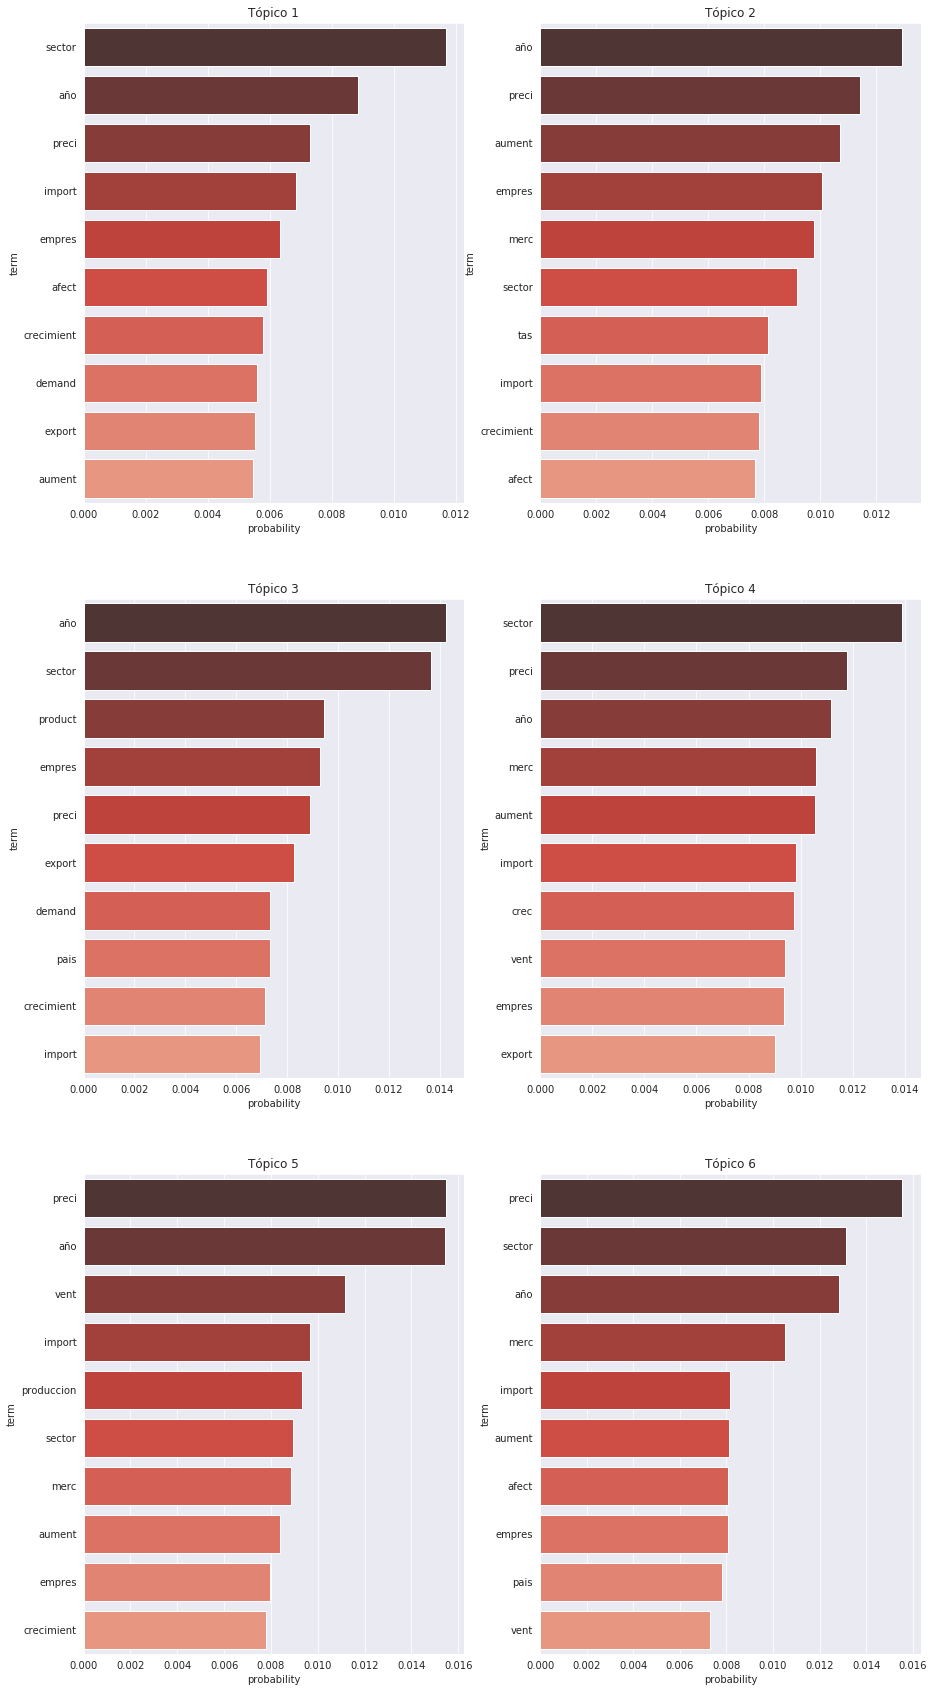

In [17]:
fiz=plt.figure(figsize=(15,30))
filas = optimo / 2
for i in range(optimo):
    dfg=pd.DataFrame(ldamodel.show_topic(i), columns=['term','prob']).set_index('term')
    
    with sns.axes_style("darkgrid"):
        plt.subplot(filas,2,i+1)
        plt.title('Tópico {}'.format(i+1))
        sns.barplot(x='prob', y=dfg.index, data=dfg, palette='Reds_d')
        plt.xlabel('probability')

plt.show()

In [18]:
# Number of Documents for Each Topic
topic_counts = df['dominante'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

3    0.4932
4    0.2055
2    0.1918
5    0.0685
1    0.0411
Name: dominante, dtype: float64

In [20]:
fiz.savefig(os.path.join(dirmodels, 'wordtopics-{:0>2}.png'.format(optimo)))